## Get data

In [1]:
from utils.mt5 import initialize_, get_currency_pair_data_

initialize_()

currency_pair = 'USDKES'
currency_df = get_currency_pair_data_(currency_pair)

currency_df.tail()

,open,high,low,close,tick_volume,spread
time,,,,,,
2024-09-09,125.56655,128.12826,124.11228,126.82226,257,251006
2024-09-10,126.79432,127.49093,125.50805,125.50805,258,323898
2024-09-11,125.48416,128.20628,124.61366,127.20400,258,211105
2024-09-12,127.19060,127.91957,126.33819,126.88836,257,288344
2024-09-13,126.88263,127.81542,126.14191,127.80160,158,306003


In [2]:
# Reset index to make the date a column
currency_df = currency_df.reset_index()
currency_df.tail()

,time,open,high,low,close,tick_volume,spread
1090,2024-09-09,125.56655,128.12826,124.11228,126.82226,257,251006
1091,2024-09-10,126.79432,127.49093,125.50805,125.50805,258,323898
1092,2024-09-11,125.48416,128.20628,124.61366,127.20400,258,211105
1093,2024-09-12,127.19060,127.91957,126.33819,126.88836,257,288344
1094,2024-09-13,126.88263,127.81542,126.14191,127.80160,158,306003


## Preprocess the data - 

### |1> Scale

In [3]:
from sklearn.preprocessing import MinMaxScaler

# Prepare data for scaling
data = currency_df[['close']].values

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

scaled_data

array([[0.02135851],
       [0.02016088],
       [0.02433081],
       ...,
       [0.35716135],
       [0.35176954],
       [0.36736965]])

### |2> Create train/test dataset

In [4]:
import numpy as np

def create_dataset(data, steps=1):
    X, y = [], []
    for i in range(len(data) - steps):
        X.append(data[i:(i + steps), 0])
        y.append(data[i + steps, 0])
    return np.array(X), np.array(y)

In [5]:
# Create datasets
steps = 10
split_idx = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:split_idx], scaled_data[split_idx:]

X_train, y_train = create_dataset(train_data, steps)
X_test, y_test = create_dataset(test_data, steps)

X_test[:5]

array([[0.81411943, 0.84330789, 0.83386573, 0.84478977, 0.81879806,
        0.86935836, 0.88772493, 0.90512772, 0.91106856, 0.84253868],
       [0.84330789, 0.83386573, 0.84478977, 0.81879806, 0.86935836,
        0.88772493, 0.90512772, 0.91106856, 0.84253868, 0.84198932],
       [0.83386573, 0.84478977, 0.81879806, 0.86935836, 0.88772493,
        0.90512772, 0.91106856, 0.84253868, 0.84198932, 0.88421027],
       [0.84478977, 0.81879806, 0.86935836, 0.88772493, 0.90512772,
        0.91106856, 0.84253868, 0.84198932, 0.88421027, 0.89210138],
       [0.81879806, 0.86935836, 0.88772493, 0.90512772, 0.91106856,
        0.84253868, 0.84198932, 0.88421027, 0.89210138, 0.90496203]])

## Train/load a model

In [6]:
from utils.lstm import train_and_save_
from tensorflow.keras.models import load_model #type:ignore
import os

# Reshape input data for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

save_filepath = f'models/lstm_{currency_pair}.keras'

# Check if the model already exists
if os.path.exists(save_filepath):
    print(f"Loading pre-trained model from {save_filepath}")
    model = load_model(save_filepath)
else:
    print(f"Training new model and saving to {save_filepath}")
    train_and_save_(steps, X_train, y_train, save_filepath)
    model = load_model(save_filepath)  # Load after training

Loading pre-trained model from models/lstm_USDKES.keras


## Testing 1,2,3...

### |1> RMSE

In [7]:
from sklearn.metrics import mean_squared_error
import math

train_predictions = scaler.inverse_transform(model.predict(X_train))
test_predictions = scaler.inverse_transform(model.predict(X_test))

y_train_orig = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, 1))

train_error = math.sqrt(mean_squared_error(y_train_orig, train_predictions))
test_error = math.sqrt(mean_squared_error(y_test_orig, test_predictions))

print(f"Train RMSE: {train_error}")
print(f"Test RMSE: {test_error}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Train RMSE: 1.3884862957582487
Test RMSE: 3.180004391915646


### |2> Forecast

In [8]:
def forecast(model, last_sequence, n_steps):
    future_predictions = []
    current_sequence = last_sequence.copy()
    for _ in range(n_steps):
        X = current_sequence.reshape(1, steps, 1)
        prediction = model.predict(X)
        future_predictions.append(prediction[0, 0])
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = prediction
    return np.array(future_predictions).reshape(-1, 1)

In [9]:
# Get the last sequence from the scaled data
last_sequence = scaled_data[-steps:]
last_sequence

array([[0.31458304],
       [0.30703631],
       [0.33681069],
       [0.33533821],
       [0.32964507],
       [0.35064041],
       [0.32819086],
       [0.35716135],
       [0.35176954],
       [0.36736965]])

In [10]:
n_future_steps = 10

future_predictions = forecast(model, last_sequence, n_future_steps)
future_predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


array([[0.34507722],
       [0.34935886],
       [0.35341215],
       [0.35518104],
       [0.3569636 ],
       [0.35906908],
       [0.3599281 ],
       [0.36229128],
       [0.36292207],
       [0.36409113]], dtype=float32)

In [11]:
future_predictions_original = scaler.inverse_transform(future_predictions)
future_predictions_original

array([[126.49659 ],
       [126.74724 ],
       [126.98452 ],
       [127.088066],
       [127.19243 ],
       [127.31568 ],
       [127.365974],
       [127.50431 ],
       [127.54123 ],
       [127.60968 ]], dtype=float32)

In [12]:
from datetime import timedelta

# Create future dates
last_date = currency_df['time'].iloc[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(n_future_steps)]
print(future_dates)

[Timestamp('2024-09-14 00:00:00'), Timestamp('2024-09-15 00:00:00'), Timestamp('2024-09-16 00:00:00'), Timestamp('2024-09-17 00:00:00'), Timestamp('2024-09-18 00:00:00'), Timestamp('2024-09-19 00:00:00'), Timestamp('2024-09-20 00:00:00'), Timestamp('2024-09-21 00:00:00'), Timestamp('2024-09-22 00:00:00'), Timestamp('2024-09-23 00:00:00')]


In [13]:
import pandas as pd

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': future_predictions_original.flatten()
})

forecast_df

,Date,Forecast
0,2024-09-14,126.496590
1,2024-09-15,126.747238
2,2024-09-16,126.984520
3,2024-09-17,127.088066
4,2024-09-18,127.192429
5,2024-09-19,127.315681
6,2024-09-20,127.365974
7,2024-09-21,127.504311
8,2024-09-22,127.541229
9,2024-09-23,127.609680


## Visuals, please...

### |1> Test Predictions vs Forecast

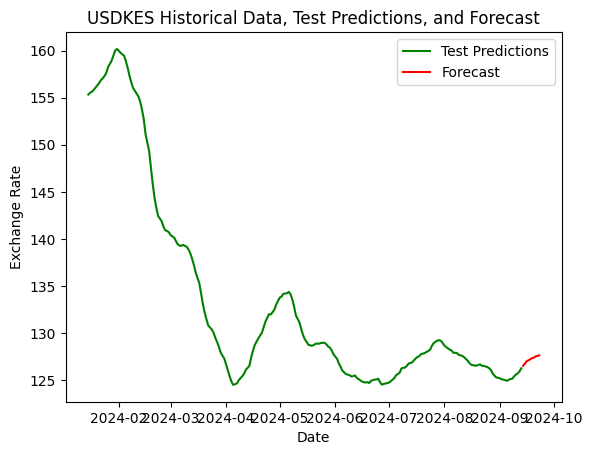

In [14]:
import matplotlib.pyplot as plt

# Plot test predictions
test_dates = currency_df['time'][split_idx+steps:split_idx+len(test_predictions)+steps]
plt.plot(test_dates, test_predictions, label='Test Predictions', color='green')

# Plot forecast
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')

plt.title(f'{currency_pair} Historical Data, Test Predictions, and Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

### |2> Historical Data vs Test Predictions vs Forecast

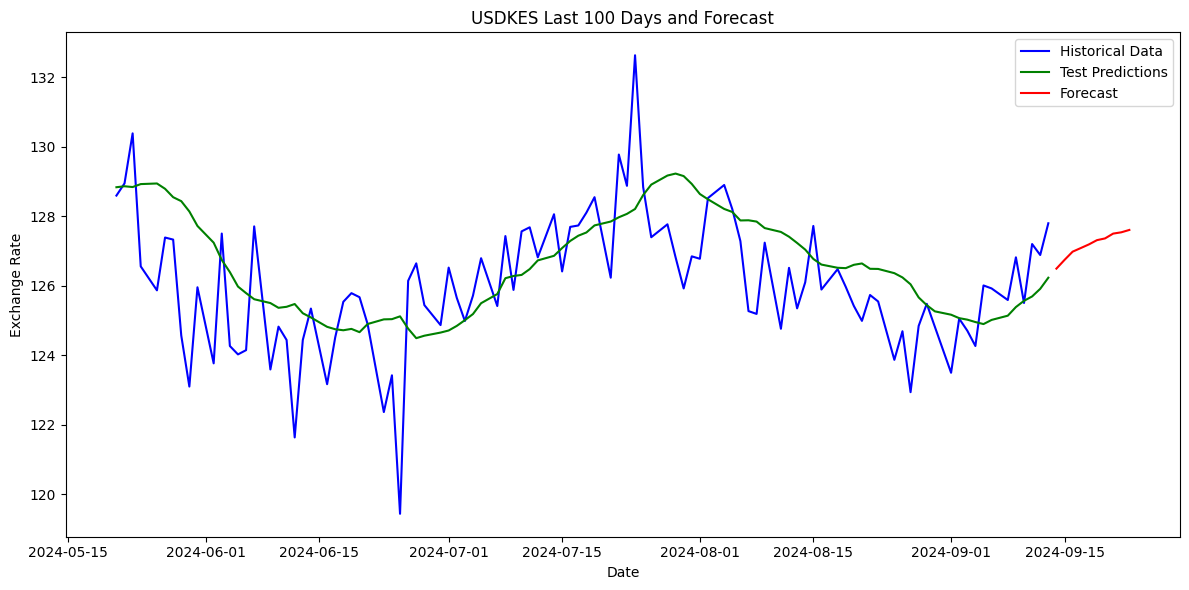

In [15]:
plt.figure(figsize=(12, 6))

last_100_days = 100
last_100_dates = currency_df['time'][-last_100_days:]
last_100_close = currency_df['close'][-last_100_days:]

plt.plot(last_100_dates, last_100_close, label='Historical Data', color='blue')
plt.plot(test_dates[-last_100_days:], test_predictions[-last_100_days:], label='Test Predictions', color='green')
plt.plot(forecast_df['Date'], forecast_df['Forecast'], label='Forecast', color='red')

plt.title(f'{currency_pair} Last 100 Days and Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.tight_layout()
plt.show()